Title: Computational Fluid Dynamics 03: Streched 1.5-dimensional FVM grid with Bernoulli flow
Date: 2017-05-06 08:30
Category: ComputationalFluidDynamics
Tags: Python, grid generation
Slug: body-fitted-grid-genereation-python
Cover: /p5102/img5102/output_7_0.png
Authors: Peter Schuhmacher
Summary: We generate different types of stretched 1-dimensional grids. We use one of them to build a FVM grid and to analyze the Bernoulli flow.

# Important ressources


This is a **fundamental work** with finite voume methd (FVM) in mind. It's not easy to read. But if you want to know all.....

- **Joe E.Thompson, Z.U.A. Warsi and C. Wayne Mastin**
- Numerical Grid Generation - Foundations and Applications 
- https://epdf.pub/numerical-grid-generation.html
- http://read.pudn.com/downloads218/ebook/1024406/GridGen_by_Thompson.pdf
- https://www.amazon.it/Joe-F.-Thompson/e/B001HPOTHC%3Fref=dbs_a_mng_rwt_scns_share
- https://www.academia.edu/3193454/Numerical_grid_generation_foundations_and_applications

Keep in mind this rules stemming from that book:

> The metric quantities should be represented numerically even when analytical expressions are available. One might have, for example, 

> If the metric coefficients were evaluated and stored at the grid points, it would perhaps be natural  using averages of the metric coefficients at the intermediate points. This, however, is not acceptable since it fails to satisfy the metric identity involved and thus would introduce spurious non-zero gradients in a uniform field. 

> Never average the metric coefficients. Rather, average the coordinate values themselves, if necessary, and then calculate the metric derivatives directly

This is **a fundamental work too**, easier to follow and to read:

- **Knupp and Steinberg**,
- The fundamentals of grid generation
- https://www.researchgate.net/publication/265361548_The_Fundamentals_of_Grid_Generation


This is the **BEST method for body-fitted structured grids**:
- **Spreijkese** 
- original paper: https://core.ac.uk/download/pdf/80112194.pdf
- similar: _- https://escholarship.org/content/qt25c7t89k/qt25c7t89k_noSplash_876eafce6a9dc328ea714341866fbd75.pdf_

Also, his distinction in

- computational grid
- parameter grid
- physical grid

is helpful and clarifying.


Here are some more helpful ressources:

- https://epdf.tips/queue/handbook-of-grid-generation.html
- https://epdf.tips/basic-structured-grid-generation-with-an-introduction-to-unstructured-grid-gener.html
- https://www.researchgate.net/publication/319562452_Application_of_numerical_grid_generation_for_improved_CFD_analysis_of_multiphase_screw_machines
- http://inis.jinr.ru/sl/Simulation/Tannehill,_CFM_and_Heat_Transfer,2_ed/chap10.pdf



# Always useful: scaling to [0..1]

In almost every circumstances it might be very helpful to squeeze your given array $\mathbf{a}$ into the interval $[0..1]$. This can be achieved with:

$$
\hat a = \frac{a-a_{min}}{a_{max} - a_{min}}
$$

Let's start with the following example: Imagine $dx$ are the random distances between the grid points of a 1-dimensional grid $x_p$ with length $n_x$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mclr
np.set_printoptions(linewidth=180, precision=3)

In [2]:
nx = 11                                  # number of grid points
dx = np.random.rand(nx-1)                # random distances between the grid points
dx

array([0.448, 0.182, 0.026, 0.44 , 0.921, 0.976, 0.988, 0.456, 0.427, 0.21 ])

We build a grid with consecutive grid points, starting at $0$

In [3]:
x1 = np.r_[0,np.cumsum(dx)]             # create an array with first element = 0, ...
                                        # ...and append the distances that are summed up
x1

array([0.   , 0.448, 0.631, 0.657, 1.096, 2.017, 2.994, 3.982, 4.438, 4.865, 5.075])

We want to keep the relative distances between the grid points but we would like to have them in the range between $0.5$ and $2$. So scale it to $[0 .. 1]$ first.

In [4]:
def scale01(z):   #--- transform z to [0 ..1]
    return (z-np.min(z))/(np.max(z)-np.min(z))

def scale11(z):   #--- transform z to [-1 ..1]
    return 2.0*(scale01(z)-0.5)

In [5]:
x2 = scale01(x1)
x2

array([0.   , 0.088, 0.124, 0.129, 0.216, 0.398, 0.59 , 0.785, 0.875, 0.959, 1.   ])

And now we fit it into the range $[0.5 .. 3]$

In [6]:
x3 = 0.5 + 2.5*x2
x3

array([0.5  , 0.721, 0.811, 0.823, 1.04 , 1.494, 1.975, 2.462, 2.686, 2.897, 3.   ])

Let's plot it

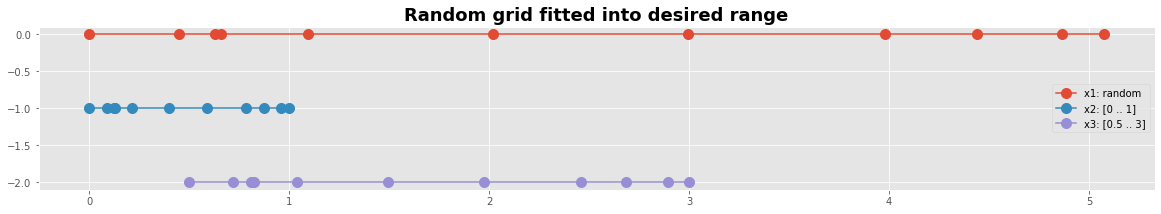

In [7]:
#---- Graphics -------------------------------
y0 = np.zeros_like(x3)              # we will  need  y-coordinates
with plt.style.context('ggplot'):
    fig, ax0 = plt.subplots(figsize=(20,3))
    plt.plot(x1, y0,'o-', ms=10,label='x1: random')
    plt.plot(x2, y0-1,'o-', ms=10,label='x2: [0 .. 1]')
    plt.plot(x3, y0-2,'o-', ms=10,label='x3: [0.5 .. 3]')
    plt.legend(loc=5)
    plt.title('Random grid fitted into desired range', fontweight='bold', fontsize='18')

# Simplify the world - model the distances

As we have seen just now: it's easy to generate the distances between the grid points first and then to compute the grid points. It's a good approach if you start your journey of grid generation in a **heuristic and creative** way. Your algorithms may then become more sophisticated step by step. So let's start by generating a grid with variable spacing by the following idea:

1. choose a minimal distance $dx_{min}$ between the grid points as a threshold value and contro parameter
2. add some vairable spacing $dx_{var}$ greater than zero to $dx_{min}$
3. compute the grid points $x$
4. fit it into the desired range

The smaller $dx_{min}$ in relation to $dx_{var}$ is the more pronounced is the grid strechting. Let's try.


In [8]:
#---- main -----------------------------------------------------
nx = 55                                   # number of grid points
ix = np.linspace(0,1,nx-1)                # auxiliary computational grid
dx_min = 0.2                              # minimal grid spacing as control parameter
dx_var = np.sin(np.pi * ix)               # variable spacing, large in the center, small at the boundaries
dx = dx_min+dx_var                        # add the two spacings 
xp = scale01(np.r_[0, np.cumsum(dx)])     # compute the scaled grid points
xp

array([0.   , 0.004, 0.01 , 0.017, 0.026, 0.036, 0.047, 0.059, 0.073, 0.087, 0.103, 0.12 , 0.138, 0.158, 0.178, 0.199, 0.221, 0.243, 0.267, 0.291, 0.316, 0.341, 0.367, 0.393,
       0.42 , 0.446, 0.473, 0.5  , 0.527, 0.554, 0.58 , 0.607, 0.633, 0.659, 0.684, 0.709, 0.733, 0.757, 0.779, 0.801, 0.822, 0.842, 0.862, 0.88 , 0.897, 0.913, 0.927, 0.941,
       0.953, 0.964, 0.974, 0.983, 0.99 , 0.996, 1.   ])

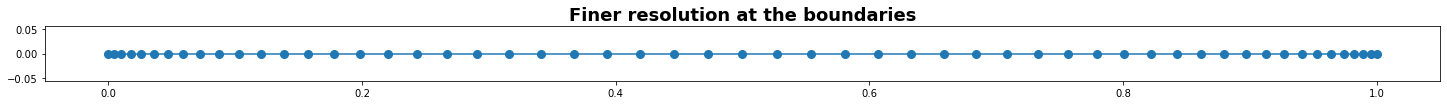

In [9]:
#---- grafics---------------------------------------------
y0 = np.zeros_like(xp)                        # we will  need  y-coordinates
with plt.style.context('fast'):
    fig, ax0 = plt.subplots(figsize=(25,1))
    plt.plot(xp, y0,'o-', ms=8,label='x1: random')
    plt.title('Finer resolution at the boundaries', fontweight='bold', fontsize='18')
    plt.show()

# class GridGeneration, 1-dimensional strechted grids

We design now some basic types of grid stretching and collect them in a `class` so they can be called easily.

In [10]:
class GridGeneration:
    def __init__(self, nx, ny):
        self.nx = nx                            # number of grid points in x-direction
        self.ny = ny                            # number of grid points in y-direction
        
    #===== scaling ====================================================================
    def scale(self, a): return (a-a.min())/(a.max()-a.min())          # scale to [0..1]
    
    #===== computational space i ======================================================
    #--- ix, iy: index [0..1], [0..1]
    def ix(self): return np.linspace(0,1,self.nx)
    def iy(self): return np.linspace(0,1,self.ny)
    
    #==== 1-dim strechting functions ==================================================
    #--- a collection of 1D stretching functions
    def stretch_regular(self,m):                        #---- regular equidistant grid
        return  np.linspace(0,1,m)
    def stretch_1_sin(self,m):                          #---- concentrate the grid points in the center
        Lx = np.pi                                          # control parameter
        ixx =  Lx*np.linspace(0,1,m-1)                      # parameter grid
        dxmin = 0.1;                                        # minimal distance as control parameter
        dxvar = 1.0-np.sin(ixx)                             # model the variable distances
        return self.scale(np.r_[0,np.cumsum(dxmin+dxvar)])  # compute the scaled grid points
    def stretch_sin(self,m):                            #---- concentrate the grid points at the boundaries
        Lx = np.pi                                          # control parameter
        ixx =  Lx*np.linspace(0,1,m-1)                      # parameter grid
        dxmin = 0.1;                                        # minimal distance as control parameter
        dxvar = np.sin(ixx)                                 # model the variable distances
        return self.scale(np.r_[0,np.cumsum(dxmin+dxvar)])  # compute the scaled grid points
    def stretch_exp(self,m):                            #---- concentrate the grid points at one boundary
        ix = np.linspace(0,1.0,m)                           # logical grid
        yStretch = 0.6; yOffset = 2.95                      # control parameters
        ixx = yStretch*(yOffset+ix)                         # parameter grid
        return self.scale(np.exp(ixx**2));                  # exp-stretching
    def stretch_minusexpsquare(self,m):                 #---- concentrate the grid points at the boundaries
        Lx, Ax = 5, 1.5                                     # control parameters
        ixx =  Lx*np.linspace(-1,1,m-1)                     # parameter grid
        dxmin = 0.1;                                        # minimal distance as control parameter
        dxvar = Ax*np.exp(-ixx**2)                          # model the variable distances
        return self.scale(np.r_[0,np.cumsum(dxmin+dxvar)])  # compute the scaled grid points

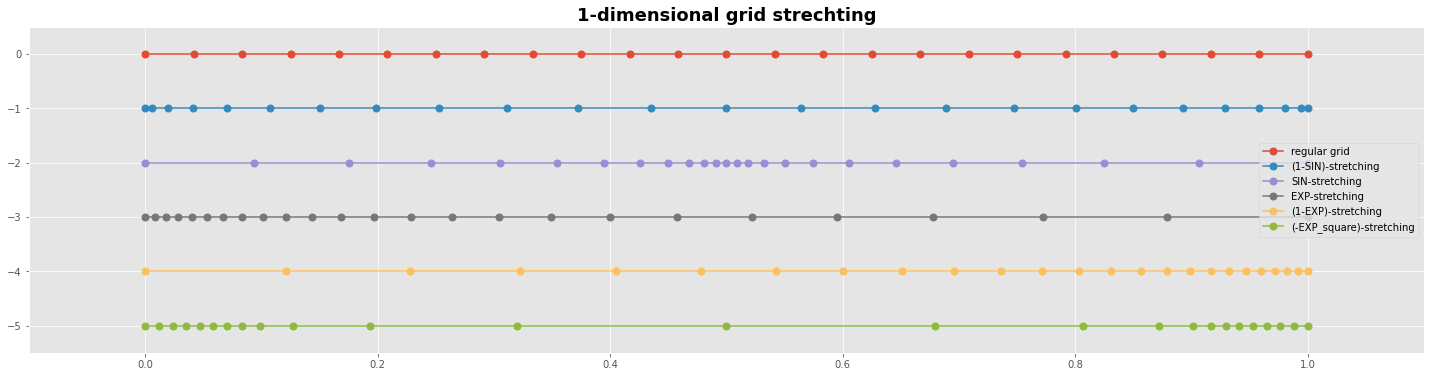

In [11]:
#---- main -----------------------------------------------------
nx = 25; ny = 1;
p = GridGeneration(nx ,ny)

X0 = p.stretch_regular(nx);  Y0 = np.zeros(nx)     # regular grid
X1 = p.stretch_sin(nx);                            # grid with higher resolution at the boundaries
X2 = p.stretch_1_sin(nx);                          # grid with higher resolution at the center
X3 = p.stretch_exp(nx);                            # grid with higher resolution at the lower/left end
X4 = p.scale(-X3);                                 # grid with higher resolution at the higher/right end
X5 = p.stretch_minusexpsquare(nx)

#---- grafics---------------------------------------------
with plt.style.context('ggplot'):
    fig, ax1 = plt.subplots(figsize=(25,6))
    ms=7
    ax1.plot(X0,Y0,  'o-', ms=ms, label='regular grid');
    ax1.plot(X1,Y0-1,'o-', ms=ms, label='(1-SIN)-stretching');
    ax1.plot(X2,Y0-2,'o-', ms=ms, label='SIN-stretching');
    ax1.plot(X3,Y0-3,'o-', ms=ms, label='EXP-stretching');
    ax1.plot(X4,Y0-4,'o-', ms=ms, label='(1-EXP)-stretching');
    ax1.plot(X5,Y0-5,'o-', ms=ms, label='(-EXP_square)-stretching');
    plt.legend()     #  loc='upper right',prop={'size': 15}
    plt.title('1-dimensional grid strechting', fontweight='bold', fontsize='18')
    plt.margins(0.1 , 0.1)
    plt.show()

# A 1.5-dimensional finite volume (FVM) grid

- for the **cell centered FVM** compute the corners/faces of the grid first. Then compute the grid points with the variables in the center of them
- for the **vertex centered FVM** compute the grid points with the variables first. Then compute the corners/faces between them

C:\Users\PC\AppData\Local\Temp/ipykernel_10608/1673676046.py:18: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o--" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(xc,yc,  'o--', lw=1 , marker='|', label='faces');


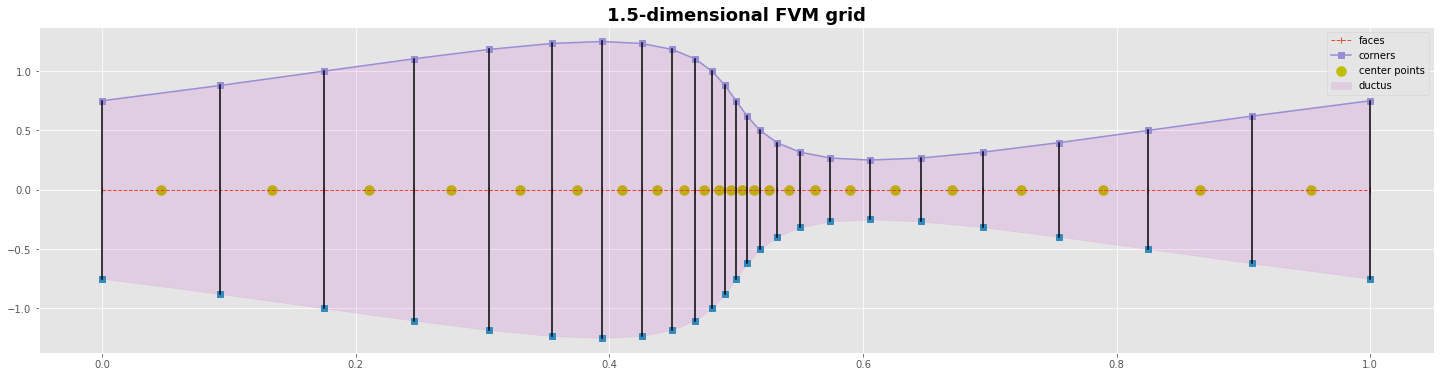

In [18]:
#---- main -----------------------------------------------------
nxc = 25; ny = 1;
nxp = nxc-1
g = GridGeneration(nxc ,ny)
xc = g.stretch_1_sin(nxc);                          # points at the corners/faces of the grid
xp = 0.5*(xc[0:nxc-1] + xc[1:nxc])                  # ponts in the centers of the volumes

S = 1.5+np.sin(g.ix()*2*np.pi)                      # size of the faces
yc0 = -0.5*S                                        # y-coord of the lower corner points
yc1 =  0.5*S                                        # y-coord of the upper corner points

#---- grafics---------------------------------------------
yc = np.zeros_like(xc)
yp = np.zeros_like(xp)
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(25,6))
    ms=7
    ax.plot(xc,yc,  'o--', lw=1 , marker='|', label='faces');
    ax.scatter(xp,yp, marker='o', s=100, color='y',label='center points')
    ax.plot(xc,yc0,'s'); ax.plot(xc,yc1, marker='s',label='corners')
    ax.fill_between(xc,yc0,yc1,color='m', alpha=0.1, label='ductus')
    ax.plot([xc,xc],[yc0,yc1],c='k')
    plt.title('1.5-dimensional FVM grid', fontweight='bold', fontsize='18')
    plt.legend(); plt.show()

# Laminar stationary flow
## Bernoulli equation from energy conservation

- https://www.schweizer-fn.de/stroemung/bernoulli/bernoulli.php
- http://www.bakker.org/dartmouth06/engs150/04-clsfn.pdf
- https://www.stroemung-berechnen.de/bernoulligleichung/

Now let's analyze analytically the velocity and the pressure field. We assume a simple stationary laminar flow. We start with the energy conservation to derive the Bernoulli equation.

$$
\begin{equation}
\begin{array}{rclcl}
\text{Flux} & : & H = \mathbf{S} \cdot \mathbf{v} &  & \\
\text{Mass conservation} & : & m = \mathbf{S} \cdot \mathbf{v} \cdot \rho & = &  const\\
\text{Energy conservation} & : & E = E_{kin} + E_{pot} + E_{pres} & = &  const\\
                           & : & E = \frac{1}{2}mv^2 + mgz + p \frac{m}{\rho} & = &  const\\
\text{Bernoulli equation}  & : & E/m = \frac{1}{2}v^2 + gz + p \frac{1}{\rho} & = &  const\\
\end{array}
\end{equation}
$$

In our example we have no elevation $\Delta z$ so we can neglect the potential energy. We can write the energy conservation in the two point form and find an iterative formula for the pressure $p$.

$$
\begin{equation}
\begin{array}{rclcl}
\frac{1}{2}v_2^2 + p_2 \frac{1}{\rho} & = & \frac{1}{2}v_1^2 + p_1 \frac{1}{\rho}\\
\frac{1}{2}v_2^2 \rho + p_2  & = & \frac{1}{2}v_1^2 \rho + p_1 \\
p_2  & = &  p_1 + \frac{1}{2} \rho (v_1^2 - v_2^2) \\
\end{array}
\end{equation}
$$

## Bernoulli equation from the Navier Stokes equation

- http://www.bakker.org/dartmouth06/engs150/04-clsfn.pdf
- https://www.continuummechanics.org/navierstokes.html
- https://www.meteo.physik.uni-muenchen.de/lehre/roger/manuskripte/Fluid_Dynamics.pdf


$$
\begin{equation}
\begin{array}{rclcl}
\text{Navier Stokes equation} & : & \rho (\frac{\partial \mathbf{v}}{\partial t} + \mathbf{v} \nabla \mathbf{v}) = -\nabla p + \mu \nabla^2 \mathbf{v} + \rho \mathbf{f} &  & \\
\text{Euler equation} & : & \rho (\frac{\partial \mathbf{v}}{\partial t} + \mathbf{v} \nabla \mathbf{v}) = -\nabla p + \rho \mathbf{f} & & \\
\text{stationary Euler equation} & : & \mathbf{v} \nabla \mathbf{v} = -\frac{1}{\rho} \nabla p + \mathbf{f} & & \\
 &  &  & Replacements &   \mathbf{v} \nabla \mathbf{v} = \nabla ( \frac{1}{2} \mathbf{v}^2) \\
 &  &  &              & \frac{1}{\rho} \nabla p = \nabla \frac{p}{\rho} \\
 &  &  &              & \mathbf{f} = -\nabla gz \\
\text{stationary Euler equation} & : & \nabla ( \frac{1}{2} \mathbf{v}^2) + \nabla \frac{p}{\rho} + \nabla gz = 0 & & \\
                                 & : & \nabla ( \frac{1}{2} \mathbf{v}^2 + \frac{p}{\rho} + gz) = 0 & & \\
\text{Bernoulli equation}        & : &  \frac{1}{2} v^2 + \frac{p}{\rho} + gz = const &  & \\
\end{array}
\end{equation}
$$

## Bernoulli flow

the following marching algorithm:

1. prescribe the flux $H$ at the inlet or at the outlet boundary
2. evaluate the velocity with $u = H/S$ at each cell face (mass conservation)
3. evaluate the profil of pressure $p$ using the iterative formula (energy conservation)

In [19]:
H = 0.75
rho = 1
v = H/S
p = np.zeros_like(v)

p[0] = 0.0
for j in range(1,nxc):
    p[j] = p[j-1] + 0.5*rho*(v[j-1]**2 - v[j]**2)
    
p

array([ 0.000e+00,  3.408e-02,  5.469e-02,  6.726e-02,  7.476e-02,  7.875e-02,  8.000e-02,  7.875e-02,  7.476e-02,  6.726e-02,  5.469e-02,  3.408e-02,  2.082e-17, -5.757e-02,
       -1.562e-01, -3.224e-01, -5.748e-01, -8.610e-01, -1.000e+00, -8.610e-01, -5.748e-01, -3.224e-01, -1.563e-01, -5.757e-02, -5.551e-17])

C:\Users\PC\AppData\Local\Temp/ipykernel_10608/1603144621.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o--" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(xc,yc,  'o--', lw=1 , marker='|');


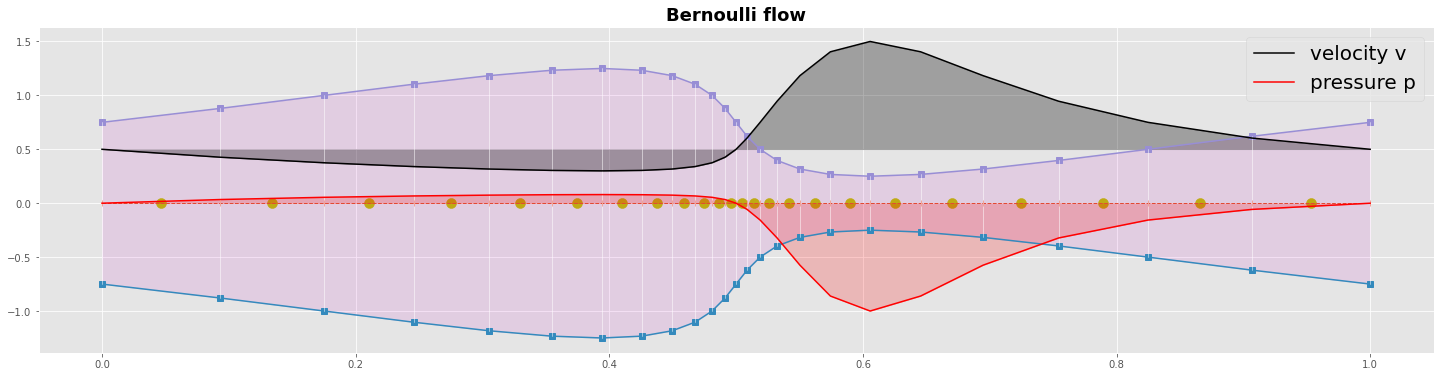

In [20]:
#---- grafics---------------------------------------------
yc = np.zeros_like(xc)
yp = np.zeros_like(xp)
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(25,6))
    ms=7
    ax.plot(xc,yc,  'o--', lw=1 , marker='|');
    ax.scatter(xp,yp, marker='o', s=100, color='y')
    ax.plot(xc,yc0,marker='s'); ax.plot(xc,yc1,marker='s')
    ax.fill_between(xc,yc0,yc1,color='m', alpha=0.1)
    ax.plot([xc,xc],[yc0,yc1], lw=0.5,c='w')
    
    ax.plot(xc,v, c='k',label='velocity v'); ax.fill_between(xc,v,v[0]*np.ones_like(v), color='k', alpha=0.3)
    ax.plot(xc,p, c='r',label='pressure p'); ax.fill_between(xc,p,0*p, color='r', alpha=0.2)
    
    plt.title('Bernoulli flow', fontweight='bold', fontsize='18')
    plt.legend(loc='upper right',prop={'size': 20}); plt.show()

# What could be next ?

There are different ways how you could continue your journey into computational fluid dynamics:

One thing are **2-dimanional grids**. The big deal is how determin the distribution of the interior grid points. With the stretched 1-dimensional grids as discussed here you are prepared to set the boundaries of a 2-dimensional grid.

An other thing is the **physics of fluid dynamics**. You might start to solve 1-dimensional diffusion and/or advection driven CFD problems. You will have to decide what type of discretization schema you prefer. **FDM** (finite differences method), **FEM** (finite element method) or **FVM** (finite volume method).

A third thing is the **numerics of equation solvers**. The easist approach is an explicit time marching FDM algorithm. Hower sooner are later you might prefer to solve a stationary equation or an inplicite time marching equation by an iterative matrix solver. You can develop some skills how to set up the sparse system equation.
